In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np

##  <center> Part A: Model Code  </center>

### 1. Polynomial and interaction features for a given degree of the polynomial.


In [2]:
def isDiff(x, y):
    if x.ndim != 1 or y.ndim != 1: 
        return True
    if x.shape[0] != y.shape[0]:
        return True
    result = False
    for i in range(x.shape[0]):
        if x[i] != y[i]:
            result = True
            break
    return result

In [3]:
def polynomialFeatures(X_train, degree):
    X = X_train[:, 1:]
    oneFeatures = list(X.transpose())
    listFeatures = []
    listFeatures.append(np.ones((X.shape[0],)))
    #print(listFeatures)
    listFeatures += list.copy(oneFeatures)
    previousFeatures = list.copy(oneFeatures)
    for i in range(1, degree):
        newFeatures = []
        for f1 in oneFeatures:
            for fp in previousFeatures:
                newVal = f1 * fp
                flag = True
                for fn in newFeatures:
                    if not isDiff(newVal, fn):
                        flag = False
                if flag:
                    newFeatures.append(newVal)
        previousFeatures.clear()
        previousFeatures += newFeatures
        listFeatures += newFeatures
    return np.vstack(listFeatures).transpose()

In [4]:
polynomialFeatures(np.array([[1, 0, 1], [1, 2, 3], [1, 4, 5]]), 1)

array([[1., 0., 1.],
       [1., 2., 3.],
       [1., 4., 5.]])

### 2. Mean squared error (mse) of two vectors

In [5]:
def mse(actual, predict):
    return np.square(actual - predict).mean()

In [6]:
def rmse(actual, predict):
    return mse(actual, predict) ** 0.5

In [7]:
Y_true = np.array([1,1])
Y_pred = np.array([0.6,1.2])

In [8]:
print(mse(Y_true, Y_pred), rmse(Y_true, Y_pred))

0.1 0.31622776601683794


### 3. Training and validation errors

In [9]:
def fold_partition(folds, data, labels):  # helper function to divide data into s equally sized portions
    data_list = np.array_split(data, folds)
    label_list = np.array_split(labels, folds)
    #print(data_list, label_list)
    return data_list, label_list

In [10]:
def sFold(folds, data, labels, model, error_function, **model_args):
    num_rows = len(data)
    partition_data, partition_label = fold_partition(folds, data, labels)
    final_res = []
    for i in range(folds):
        X_train = []
        y_train = []
        for j in range(folds):
            if j == i:
                continue
            X_train.append(partition_data[j])
            y_train.append(partition_label[j])
        X_train = np.vstack(X_train)
        #print(y_train)
        y_train = np.vstack(y_train)
        #print(X_train)
        #print(y_train)
        model.fit(X = X_train, y = y_train, **model_args)
        label_train = model.predict(X_train)
        label_valid = model.predict(partition_data[i])
        #print('DEBUGGGGGGG')
        #print(label_valid.shape, partition_label[i].shape)
        final_res.append(np.array([error_function(label_train, y_train), error_function(label_valid, partition_label[i])]))
    final_res = np.vstack(final_res)
    #print(final_res)
    return np.mean(final_res, axis = 0)

In [11]:
def learning_curve(model, X, y, cv, train_size=2, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    if type(train_size) == float:
        train_size = int(X.shape[0] * train_size)
    num_train = 0
    final = []
    while num_train < X.shape[0]:
        num_train = min(X.shape[0], num_train + train_size)
        X_train = X[: num_train, :]
        y_train = y[: num_train, :]
        res = sFold(cv, X_train, y_train, model, rmse, **{'learning_rate': learning_rate, 'epochs': epochs, 'tol': tol, 'regularizer': regularizer, 'lambd': lambd})
        final.append(res)
    final = np.vstack(final)
    return final[:, 0], final[:, 1]

### 4. Plot the training and validation root mean square error (rmse) values of the data matrix X for various polynomial degree

In [12]:
def plot_polynomial_model_complexity(model, X, y, cv, maxPolynomialDegree, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    final = []
    for deg in range(1, maxPolynomialDegree + 1):
        #print(deg)
        X_train = polynomialFeatures(X, deg)
        res = sFold(cv, X_train, y, model, rmse, **{'learning_rate': learning_rate, 'epochs': epochs, 'tol': tol, 'regularizer': regularizer, 'lambd': lambd})
        final.append(res)
    return np.vstack(final)

### 5. Linear_Regression model class

In [13]:
class Linear_Regression:
    def __init__(self):
        pass
    
    def fit(self, X, y, learning_rate= 0.01, epochs=1000, tol= None, regularizer = None, lambd = 0.0, **kwargs):
        #X = np.hstack((np.ones((X_train.shape[1], 1)) ,X_train))
        #print(X)
        # theta_hat = np.zeros((X.shape[1], 1))
        theta_hat = np.random.uniform(0, 1, (X.shape[1], 1))
        num_iter = 0
        previous_error = 99999
        print("shape: ", X.shape, theta_hat.shape, y.shape)
        while True: 
            #print(learning_rate / X.shape[0])
            #print(X)
            temp1 = (learning_rate / X.shape[0]) * X.transpose()
            temp2 = np.matmul(X, theta_hat) - y
            
            # theta_hat = theta_hat - np.matmul(temp1, temp2)
            if regularizer == 'l1':
                theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * theta_hat
            elif regularizer == 'l2':
                theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * np.sign(theta_hat)
            else:
                theta_hat = theta_hat - np.matmul(temp1, temp2)
            # print(num_iter, theta_hat)
            num_iter += 1
            if tol == None and num_iter >= epochs:
                break
            error = mse(np.matmul(X, theta_hat), y)
            if tol != None and tol > previous_error - error:
                break
            previous_error = error
        self.theta = theta_hat
        return
    
    def predict(self, X):
        return np.matmul(X, self.theta)

In [14]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
X = np.array([[1, 1.1, 2.1], [1, 4.3, -1.5], [1, 6.4, -3.7], [1, 1.7, 1.5]])
y = np.array([[0], [0.1], [0.3], [-0.2]])
lr = Linear_Regression()
learning_curve(lr, X, y, 2)

shape:  (1, 3) (3, 1) (1, 1)
shape:  (1, 3) (3, 1) (1, 1)
shape:  (2, 3) (3, 1) (2, 1)
shape:  (2, 3) (3, 1) (2, 1)


(array([3.19189120e-16, 3.74593758e-13]), array([0.74030302, 0.18217142]))

In [17]:
df = pd.read_csv('data.csv')
y = np.array(df['y']).reshape(-1, 1)

X = np.array(df.drop(columns=['x']))
print("x", type(X[0]))
print("y", type(y[0][0]))
lr = Linear_Regression()
X_train_std = X.copy()
    #X_test_std  = X_test.copy()
mean = np.mean(X, axis=0)
print("mean", mean)
std = np.std(X, axis=0)
print("std", std)
#     #X_test_std = (X_test_std - mean) / std
X_train_std = (X_train_std - mean) / (np.array(std)+1e-5)

X = polynomialFeatures(X, 2)
lr.fit(X, y, learning_rate=0.01, epochs=10001, regularizer='l2')
print("rmse: ", rmse(lr.predict(X), y))

x <class 'numpy.ndarray'>
y <class 'numpy.float64'>
mean [1.         2.83333333]
std [0.         0.38239014]
shape:  (15, 3) (3, 1) (15, 1)
rmse:  0.006986588450198034


## <center>  Part B: Data Processing </center>

### 6. Read in data file as a Panda data frame

In [19]:
df = pd.read_csv('winequality-red.csv', sep=';')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [20]:
df.tail(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [21]:
print("(Rows, Columns) = ", df.shape)

(Rows, Columns) =  (1599, 12)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [23]:
# Count all NaN in a DataFrame (both columns & Rows)
df.isnull().sum().sum()

0

### 7. Summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles

In [24]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [25]:
# count the frequency that a value occurs in quality column
print(df["quality"].value_counts())
print('')

print('Proportion of each class in the data:')
print(df['quality'].value_counts() / len(df))

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Proportion of each class in the data:
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


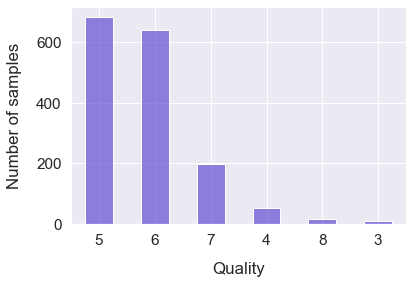

In [26]:
# plot in decreasing sample counts
sns.set(font_scale=1.4)
df['quality'].value_counts().plot.bar(color=(0.3, 0.2, 0.8, 0.6),figsize=(6, 4), rot=0)
plt.xlabel("Quality", labelpad=14)
plt.ylabel("Number of samples", labelpad=14)
#plt.title("Number of samples in each group", y=1.02);
plt.show()

In [27]:
quality_count = df["quality"].value_counts().to_frame().reset_index().rename(columns={"index": "quality", "quality": "count"})

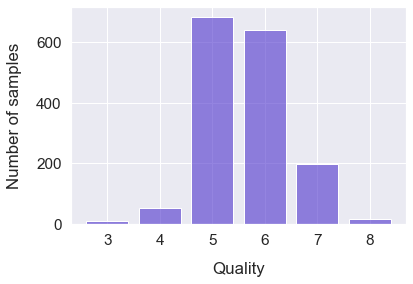

In [28]:
# plot in increasing quality order
fig = plt.figure(figsize =(6,4)) 
plt.bar(quality_count['quality'], quality_count['count'],color=(0.3, 0.2, 0.8, 0.6)) 
plt.xlabel("Quality", labelpad=14)
plt.ylabel("Number of samples", labelpad=14)
plt.show()

### 8. Shuffle the rows of the data

In [29]:
df = df.sample(frac=1)

In [30]:
print("(Rows, Columns)) = ", df.shape)

(Rows, Columns)) =  (1599, 12)


In [31]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1492,6.2,0.65,0.06,1.6,0.050,6.0,18.0,0.99348,3.57,0.54,11.95,5
579,10.6,0.31,0.49,2.2,0.063,18.0,40.0,0.99760,3.14,0.51,9.80,6
1138,7.5,0.41,0.15,3.7,0.104,29.0,94.0,0.99786,3.14,0.58,9.10,5


In [32]:
df.tail(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1570,6.4,0.36,0.53,2.2,0.230,19.0,35.0,0.99340,3.37,0.93,12.4,6
1257,7.0,0.58,0.28,4.8,0.085,12.0,69.0,0.99633,3.32,0.70,11.0,6
36,7.8,0.60,0.14,2.4,0.086,3.0,15.0,0.99750,3.42,0.60,10.8,6


### 9. Generate pair plots

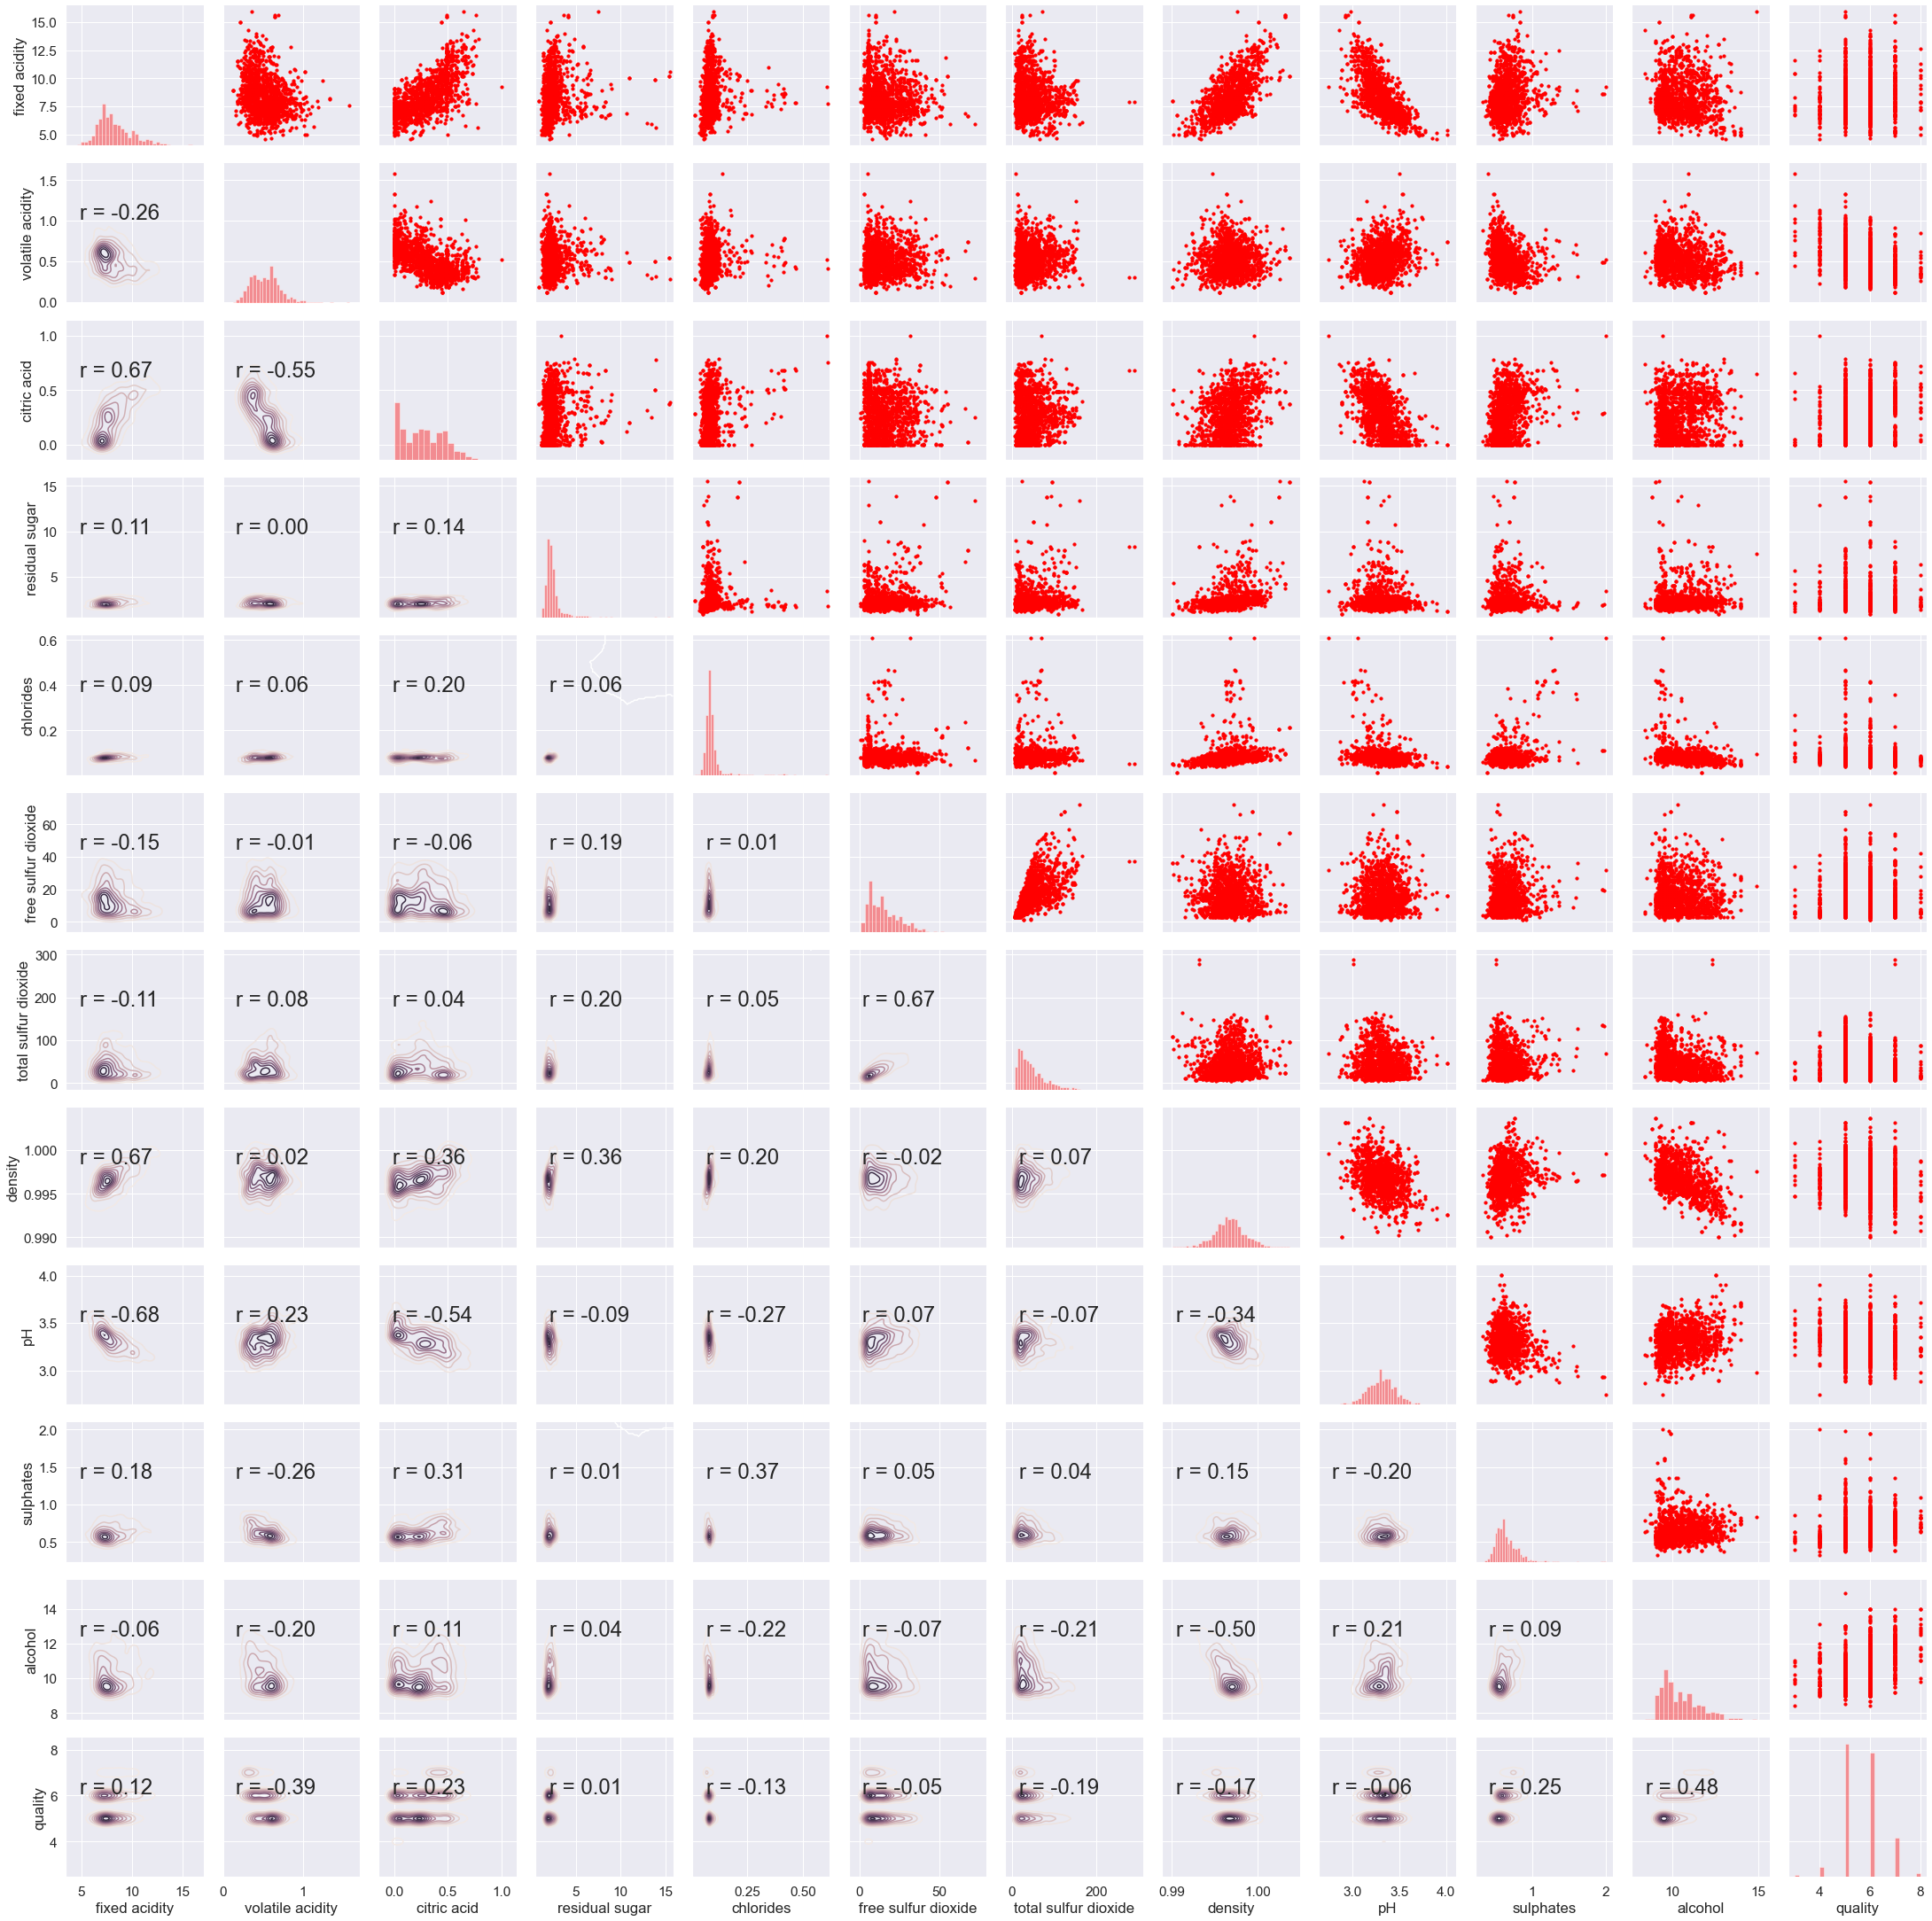

In [33]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

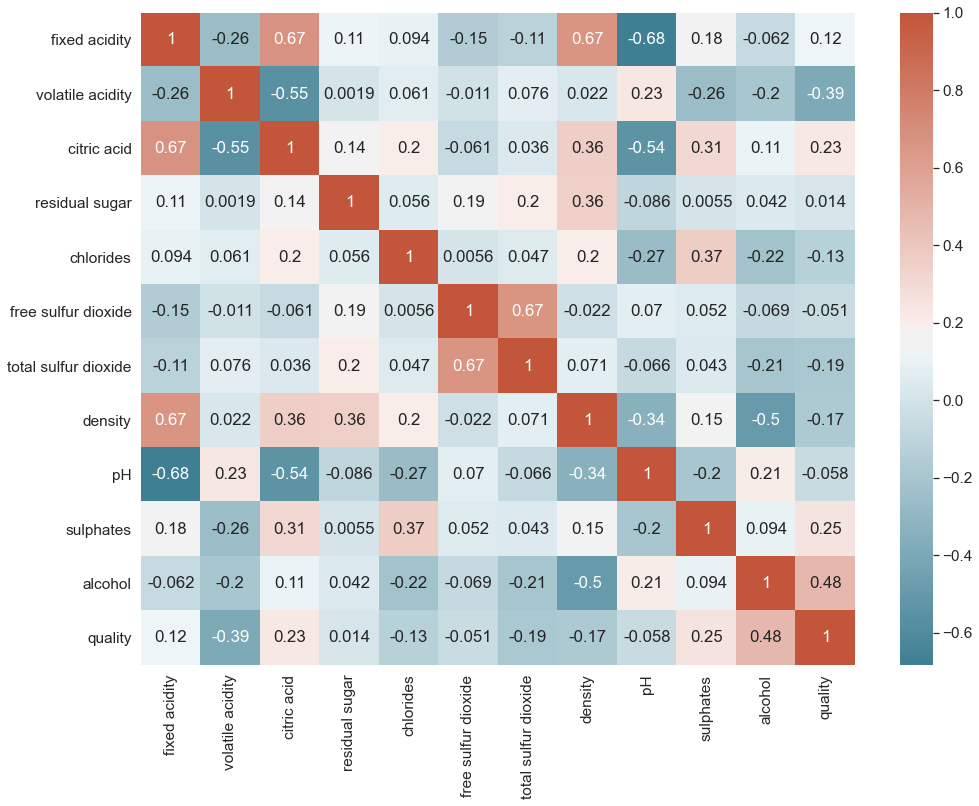

In [34]:
# Below is a similar figure, providing the same information
plt.subplots(figsize=(16, 12))
sns.heatmap(df.corr(), annot = True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [35]:
corrs = df.corr()['quality'].drop('quality')

#### Drop features which are weakly correlated with quality

We set a correlation threshold of 0.05 to remove features which are weakly correlated with quality. That means all features which have an absolute correlation score smaller than 0.05 were removed. With this threshold, residual sugar feature was removed.

In [36]:
def select_features(correlation_threshold):
    absolute_corrs = corrs.abs()
    high_correlations = absolute_corrs[absolute_corrs > correlation_threshold].index.values.tolist()
    return high_correlations

In [37]:
# only features with correlation > 0.05 are selected 
remaining_features = select_features(0.05)
print("Remaining features are " ,remaining_features)

Remaining features are  ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


#### Create the data matrix (X) and the target vector (y)

In [38]:
X = df[remaining_features] 
y = df['quality']
# convert dataframe to numpy array
X = X.to_numpy()
y = y.to_numpy()

In [39]:
print("(Rows, Columns) = ", X.shape)
print("(Rows, Columns) = ", y.shape)

(Rows, Columns) =  (1599, 10)
(Rows, Columns) =  (1599,)


#### Partition function

In [40]:
# X,y = numpy arrays, t = percent of testing data (e.g. 0.2)
def partition(X, y, t):
    num_rows = len(y)
    index_cutoff = int(num_rows * (1-t))
    X_train, X_test = X[:index_cutoff,:], X[index_cutoff:,:]
    y_train, y_test = y[:index_cutoff],y[index_cutoff:]
    return X_train, X_test, y_train, y_test

In [41]:
X_train, X_test, y_train, y_test = partition(X, y, 0.2)
print ('Train set', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set (1279, 10) (1279,)
Test set: (320, 10) (320,)


#### Standardize feature

In [42]:
def standardize(X_train,X_test):
    X_train_std = X_train.copy()
    X_test_std  = X_test.copy()
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis = 0)
    X_test_std = (X_test_std - mean) / std
    X_train_std = (X_train_std - mean) / std
    return X_train_std, X_test_std

In [43]:
X_train_std, X_test_std = standardize(X_train,X_test)

## <center> Part C: Model Evaluation </center>

### 10. Model selection via Hyperparameter tuning

In [44]:
args = {'lambd': 0, 'learning_rate': 0, 'regularizer' : None}
y_train = y_train.reshape(-1, 1)
mean = np.mean(y_train, axis = 0)
std = np.std(y_train, axis = 0)
y_train_std = (y_train - mean) / std

In [45]:
lr = Linear_Regression()
for lambd in [1.0, 0, 0.1, 0.01, 0.001, 0.0001]:
    for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
        for regularizer in ['l1', 'l2']:
            args['lambd'] = lambd
            args['learning_rate'] = learning_rate
            args['regularizer'] = regularizer
            result = sFold(10, X_train, y_train, lr, mse, **args)
            print(args)
            print(result * std)

shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape: 

<ipython-input-5-6b64baa05c39>:2: RuntimeWarning: overflow encountered in square
  return np.square(actual - predict).mean()
D:\Programs\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-13-18727acdb310>:30: RuntimeWarning: overflow encountered in matmul
  error = mse(np.matmul(X, theta_hat), y)
<ipython-input-13-18727acdb310>:17: RuntimeWarning: overflow encountered in matmul
  temp2 = np.matmul(X, theta_hat) - y
<ipython-input-13-18727acdb310>:21: RuntimeWarning: invalid value encountered in matmul
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * theta_hat
<ipython-input-13-18727acdb310>:21: RuntimeWarning: overflow encountered in matmul
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * theta_hat
<ipython-input-13-18727acdb310>:30: RuntimeWarning: invalid value encountered in matmul
  err

 (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 1.0, 'learning_rate': 0.1, 'regularizer': 'l1'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape: 

<ipython-input-13-18727acdb310>:23: RuntimeWarning: invalid value encountered in sign
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * np.sign(theta_hat)
<ipython-input-13-18727acdb310>:23: RuntimeWarning: invalid value encountered in matmul
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * np.sign(theta_hat)


 (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 1.0, 'learning_rate': 0.1, 'regularizer': 'l2'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape: 

<ipython-input-13-18727acdb310>:23: RuntimeWarning: overflow encountered in matmul
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * np.sign(theta_hat)
<ipython-input-13-18727acdb310>:23: RuntimeWarning: invalid value encountered in subtract
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * np.sign(theta_hat)


 (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 1.0, 'learning_rate': 0.01, 'regularizer': 'l1'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 1.0, 'learning_rate': 0.01, 'regularizer': 'l2'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10)

<ipython-input-13-18727acdb310>:21: RuntimeWarning: invalid value encountered in multiply
  theta_hat = theta_hat - np.matmul(temp1, temp2) - (learning_rate * lambd / X.shape[0]) * theta_hat


shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0, 'learning_rate': 0.1, 'regularizer': 'l1'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0, 'learning_rate': 0.1, 'regularizer': 'l2'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0, 'lea

shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0.01, 'learning_rate': 0.01, 'regularizer': 'l2'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0.01, 'learning_rate': 0.001, 'regularizer': 'l1'}
[nan nan]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  

shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0.0001, 'learning_rate': 0.0001, 'regularizer': 'l1'}
[0.55644063 0.57048263]
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1151, 10) (10, 1) (1151, 1)
shape:  (1152, 10) (10, 1) (1152, 1)
{'lambd': 0.0001, 'learning_rate': 0.0001, 'regularizer': 'l2'}
[0.6228831  0.65818734]


### 11. Evaluate your model on the test data and report the mean squared error.

In [46]:
lr.fit(X_train, y_train, learning_rate = 0.0001, regularizer = 'l2', lambd = 0.0001)

shape:  (1279, 10) (10, 1) (1279, 1)


In [47]:
y_pre = lr.predict(X_test)
rmse(y_pre, y_test)

0.8940012249566868

### 12. Using the best model plot the learning curve. Use the rmse values obtained from the “learning_curve” function to plot this curve.

In [48]:
r1, r2 = learning_curve(lr, X_train, y_train, 10, 0.2, learning_rate = 0.0001, regularizer = 'l2', lambd = 0.0001)

shape:  (229, 10) (10, 1) (229, 1)
shape:  (229, 10) (10, 1) (229, 1)
shape:  (229, 10) (10, 1) (229, 1)
shape:  (229, 10) (10, 1) (229, 1)
shape:  (229, 10) (10, 1) (229, 1)
shape:  (230, 10) (10, 1) (230, 1)
shape:  (230, 10) (10, 1) (230, 1)
shape:  (230, 10) (10, 1) (230, 1)
shape:  (230, 10) (10, 1) (230, 1)
shape:  (230, 10) (10, 1) (230, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (459, 10) (10, 1) (459, 1)
shape:  (688, 10) (10, 1) (688, 1)
shape:  (688, 10) (10, 1) (688, 1)
shape:  (688, 10) (10, 1) (688, 1)
shape:  (688, 10) (10, 1) (688, 1)
shape:  (688, 10) (10, 1) (688, 1)
shape:  (689, 10) (10, 1) (689, 1)
shape:  (689, 10) (10, 1) (689, 1)
shape:  (689, 10) (10, 1) (689, 1)
shape:  (689, 10) (1

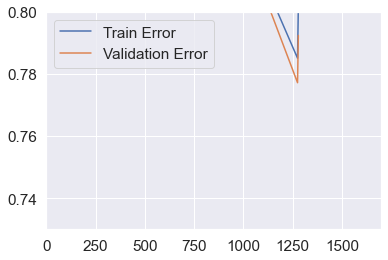

In [49]:
training_size = int(0.2 * X_train.shape[0])
x_axis = []
num_train = 0
while num_train < X_train.shape[0]:
    num_train = min(X_train.shape[0], num_train + training_size)
    x_axis.append(num_train)
plt.axis([0, 1700, 0.73, 0.8])
plt.plot(x_axis, r1, label = "Train Error")
plt.plot(x_axis, r2, label = 'Validation Error')
plt.legend(loc= 'best')

### 13. Determine the best model hyperparameter values for the training data matrix with polynomial degree 3 and plot the learning curve. Use the rmse values obtained from the “learning_curve” function to plot this curve.

In [50]:
X_train3 = polynomialFeatures(X_train, 3)

In [ ]:
lr = Linear_Regression()
for lambd in [1.0, 0, 0.1, 0.01, 0.001, 0.0001]:
    for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
        for regularizer in ['l1', 'l2']:
            args['lambd'] = lambd
            args['learning_rate'] = learning_rate
            args['regularizer'] = regularizer
            args['tol'] = 0.0001
            result = sFold(10, X_train3, y_train, lr, mse, **args)
            print(args)
            print(result * std)

### 14. Using the plot_polynomial_model_complexity function plot the rmse values for the training and validation folds for polynomial degree 1, 2, 3, 4 and 5. 

### 15. Implement the Stochastic Gradient Descent Linear Regression algorithm. 

In [ ]:
def f(x, y):
    return x + y

In [ ]:
f(**{'x' : 5, 'y' : 6})